In [1]:
import torch
torch.manual_seed(0)

import torchzero as tz
from visualbench import FunctionDescent, test_functions

# 1. First order methods

First order methods make use of the gradient of the objective function $\nabla f(x_t)$. The simplest 1-st order method is gradient descent where on step $t$ gradient $\nabla f(x_t)$ is multiplied by step size $\eta$ and subtracted from parameters $x_t$:

$$
x_{t+1} \leftarrow x_t - \eta \nabla f(x_t)
$$

The step size $\eta$ can be fixed, set to a pre-determined step size schedule, determined via a line search, or via a more sophisticated strategy.

Other first order methods modify the direction $-\nabla f(x_t)$ by incorporating momentum (see [2. Momentum](../2.%20Momentum.ipynb)), adaptive per-weight step sizes (see [3. Adaptive methods](../3.%20Adaptive%20methods.ipynb)), etc.

On this page we will focus on methods that use the pure gradient direction $\nabla f(x_t)$ and differ in the way step size $\eta$ is determined.

### 1.1 GD with constant step size

To run GD with fixed step size, all we need to do is add the `LR` module and specify our step size.

Let's run it on
$$
f(x,y) = x^2 + y^2 + 1.99 * x * y
$$

This is badly scaled quadratic function where GD requires many iterations to converge. The gradient at initial point is large, therefore step size needs to be small to avoid overshooting. However as GD approaches the valley, gradient becomes small, and due to small step size it makes little progress.

finished in 12.5s., reached loss = 6.88e-10                                      


<Axes: >

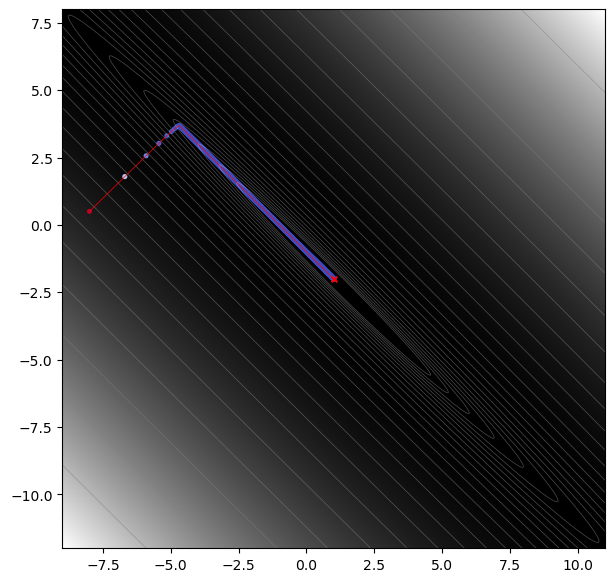

In [2]:
func = FunctionDescent('ill2')
optimizer = tz.Modular(func.parameters(), tz.m.LR(1e-1))
func.run(optimizer, max_steps=10000)
func.plot(log_contour=True)

### 1.2 GD with line search
A line search tests multiple step sizes until some some criteria are satisfied. For more details on line searches see [7. Line search](../7.%20Line%20search.ipynb). 

We will use the ``StrongWolfe`` line search which is almost exact on a quadratic function.

The function here is 
$$
f(x) = (2*x + 3*y - 5)^2 + (5*x - 2*y - 3)^2
$$

On this function, another drawback of GD can be observed, which is the "staircase" path it takes. There is a simple modification which avoids this behaviour - the conjugate gradient method, described in [6. Conjugate gradient](../6.%20Conjugate%20gradient.ipynb).

finished in 0.1s., reached loss = 0                                      


<Axes: >

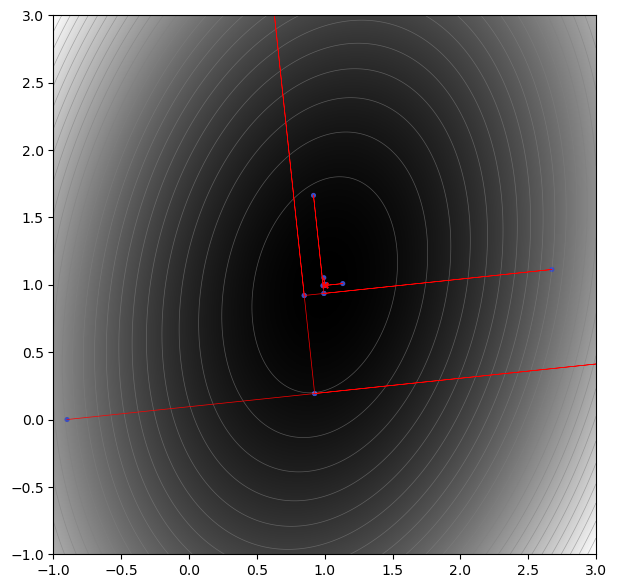

In [3]:
func = FunctionDescent('lstsq')
optimizer = tz.Modular(func.parameters(), tz.m.StrongWolfe(a_init='first-order', c2=0.1))
func.run(optimizer, max_steps=20)
func.plot()

### 1.3 GD with Polyak's step size
Polyak's step size determines the step size assuming the function is convex and the objective value at the minimizer $f^*$ is known.

$$
\eta_{\text{polyak}} = \frac{f(x_t) - f^*} {\nabla f(x_t)^T \nabla f(x_t)}
$$

finished in 0.1s., reached loss = 3.87e-12                                      


<Axes: >

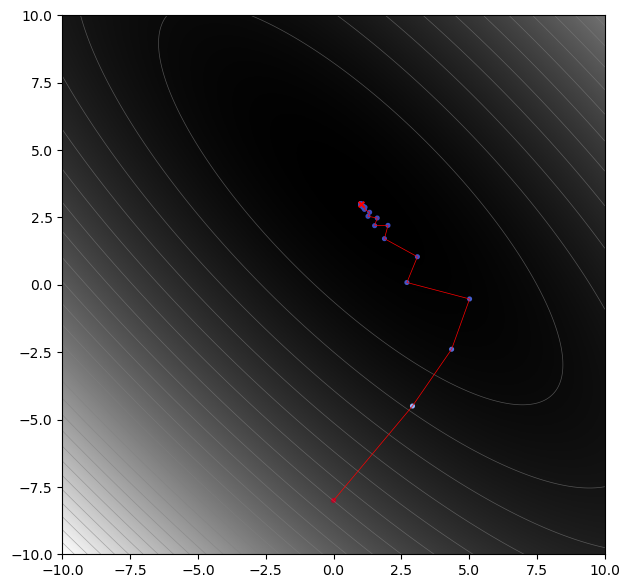

In [4]:
func = FunctionDescent('booth')
optimizer = tz.Modular(func.parameters(), tz.m.PolyakStepSize())
func.run(optimizer, max_steps=50)
func.plot()

### 1.4 GD with Barzilai–Borwein step size
Barzilai–Borwein (BB) method is a way to determine the step size using a scalar approximation to the quasi-newton methods.

There are two variants of the BB - the "long" step size and the "short" step size.
$$
\eta_{\text{long}} = \frac{\Delta x^T \cdot \Delta x} {\Delta x^T \cdot \Delta g}
$$
$$
\eta_{\text{short}} = \frac{\Delta x^T \cdot \Delta g} {\Delta g^T \cdot \Delta g}
$$

Here $\Delta x=x_t-x_{t-1}$ is difference in parameters between previous and current step, and $\Delta g=\nabla f(x_t)-\nabla f(x_{t-1})$ is difference in gradients.

Because BB uses difference in gradients, it is not suitable for stochastic optimization without some kind of variance reduction.

Reference: *[Barzilai, Jonathan, and Jonathan M. Borwein. "Two-point step size gradient methods." IMA journal of numerical analysis 8.1 (1988): 141-148.](https://moscow.sci-hub.se/2720/4e5276c5a82d5e222fba37921001bc11/10.1093@imanum@8.1.141.pdf)*

finished in 0.0s., reached loss = 0                                      


<Axes: >

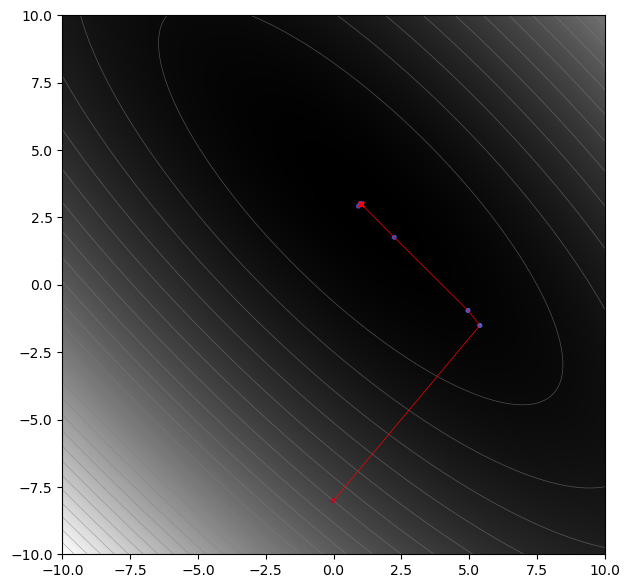

In [5]:
func = FunctionDescent('booth')
optimizer = tz.Modular(func.parameters(), tz.m.BarzilaiBorwein())
func.run(optimizer, max_steps=20)
func.plot()

### 1.5 BBstab

Stabilized Barzilai-Borwein method uses the Barzilai–Borwein step-size, except the norm of the update is clipped by hyperparameter $\Delta$. The hyperparameter can be selected adaptively, where first few steps are performed without norm clipping, and $\Delta$ is set to the norm of the smallest update times $c$ and remains fixed for the remainding steps, where $c$ is a hyperparameter can can be set to 0.2 to 0.3.

BBStab can minimize the rosenbrock function where methods above tend to require a very large number of iterations.

Reference: *[Burdakov, Oleg, Yuhong Dai, and Na Huang. "Stabilized barzilai-borwein method." Journal of Computational Mathematics (2019): 916-936.](https://arxiv.org/abs/1907.06409)*

finished in 1.3s., reached loss = 1.37e-07                                      


<Axes: >

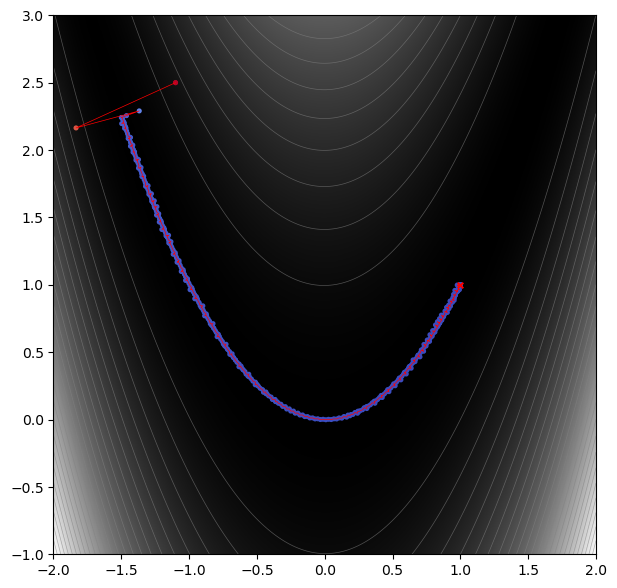

In [6]:
func = FunctionDescent('rosen')
optimizer = tz.Modular(func.parameters(), tz.m.BBStab())
func.run(optimizer, max_steps=500)
func.plot()

### 1.6 AdGD and AdGD-2

Adaptive gradient descent (AdGD) and Adaptive gradient descent-2 (AdGD-2) are completely tuning-free step size methods. Here is the update rule from the paper:

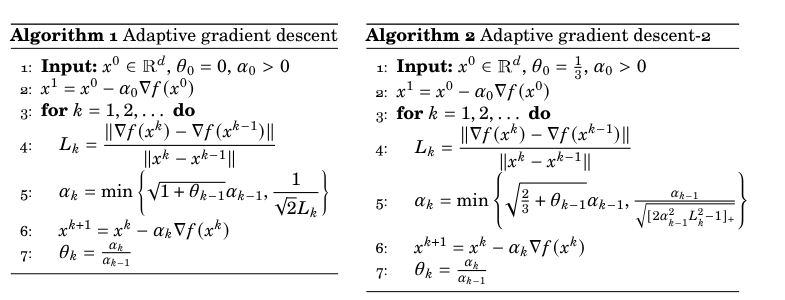

AdGDs also use difference in gradients, so they aren't suitable for stochastic optimization.

Reference: *[Malitsky, Yura, and Konstantin Mishchenko. "Adaptive proximal gradient method for convex optimization." Advances in Neural Information Processing Systems 37 (2024): 100670-100697.](https://arxiv.org/abs/2308.02261)*

finished in 2.2s., reached loss = 0.000282                                      


<Axes: >

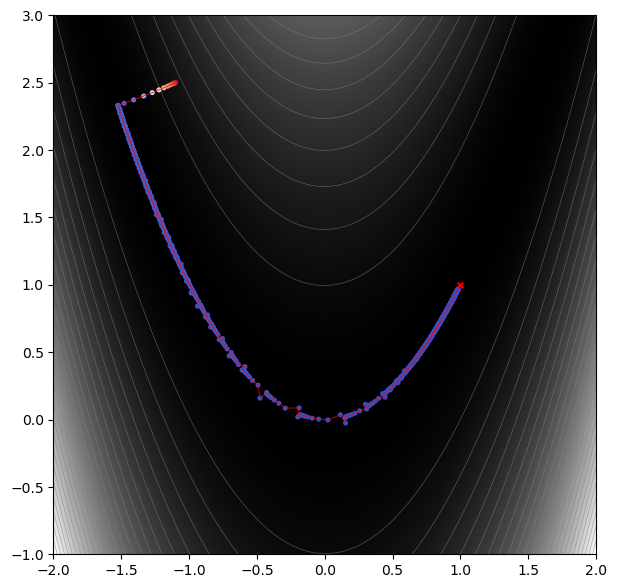

In [2]:
func = FunctionDescent('rosen')
optimizer = tz.Modular(func.parameters(), tz.m.AdGD(variant=2))
func.run(optimizer, max_steps=2000)
func.plot()

### 1.7 GD with trust region
Another way to determine the step size is by using a trust region. For more details on trust region see [8. Trust Region](../8.%20Trust%20region.ipynb). 

Trust regions typically require hessian or approximation, but it is possible to assume hessian to be identity matrix by passing `hess_module=Identity()`.

The `TrustCG` module, despite having "CG" in its name, will use exact solution if it can be calculated efficiently, which it can be in our case.

`rho_good = rho_bad = 0` means any step that decreased the function value increases the trust radius, otherwise trust radius is decreased.

finished in 4.3s., reached loss = 0.00381                                      


<Axes: >

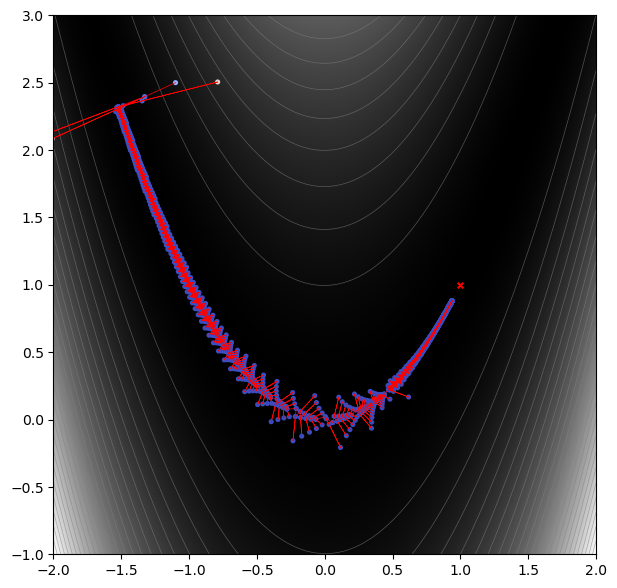

In [ ]:
func = FunctionDescent('rosen')
optimizer = tz.Modular(
    func.parameters(), 
    tz.m.TrustCG(
        hess_module=tz.m.Identity(),
        rho_good=0,
        rho_bad=0
    )
)
func.run(optimizer, max_steps=2000)
func.plot()

### 1.8 BB with trust region

BB can also be used with trust region, usually outperforming identity approximation.

finished in 2.0s., reached loss = 0.000463                                      


<Axes: >

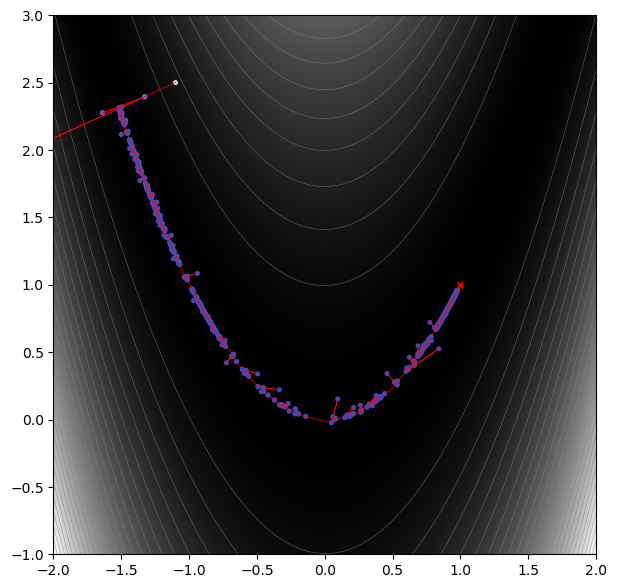

In [ ]:
func = FunctionDescent('rosen')
optimizer = tz.Modular(
    func.parameters(),
    tz.m.TrustCG(
        hess_module=tz.m.BarzilaiBorwein(),
        rho_good=0,
        rho_bad=0,
    )
)
func.run(optimizer, max_steps=1000)
func.plot()

### 1.9 Normalized GD

Normalized GD is a simple modification to GD where the gradient is normalized to have unit norm.

$$
x_{t+1} \leftarrow x_t - \eta \frac{\nabla f(x_t)}{||\nabla f(x_t) ||_2}
$$

Other norms or measures can also be used instead of L2 norm $||\nabla f(x_t) ||_2$, for example the mean absolute deviation $\frac{1}{n}\sum\limits_{i=1}^{n}|\nabla f(x_t)|_i$

finished in 0.3s., reached loss = 0.0123                                      


<Axes: >

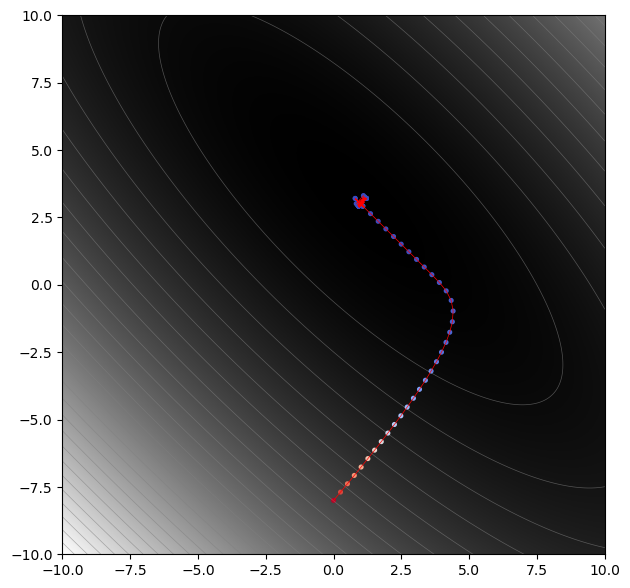

In [10]:
func = FunctionDescent('booth')
optimizer = tz.Modular(func.parameters(), tz.m.Normalize(), tz.m.LR(4e-1))
func.run(optimizer, max_steps=100)
func.plot()

### 1.10 SignGD

SignGD updates parameters with sign of the gradient. It was originally suggested for distributed optimization since it compresses gradient information to just the sign, however it can also outperform GD in some cases due to inherent normalization.

$$
x_{t+1} \leftarrow x_t - \eta \text{ sign}(\nabla f(x_t))

finished in 0.1s., reached loss = 0.08                                      


<Axes: >

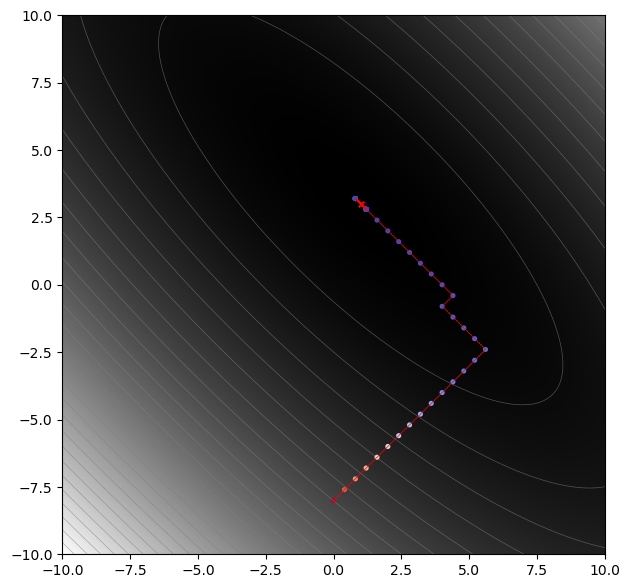

In [11]:
func = FunctionDescent('booth')
optimizer = tz.Modular(func.parameters(), tz.m.Sign(), tz.m.LR(4e-1))
func.run(optimizer, max_steps=100)
func.plot()